# Generating data with arbitrary latent dimensionality and correlation structure

In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import importlib

In [2]:
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Resources'
r_path = "/Library/Frameworks/R.framework/Resources/bin"
os.environ["PATH"] = r_path + ";" + os.environ["PATH"]

import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

In [3]:
import importlib

## Preprocessing template data
### Read data

In [4]:
data_gene = sc.read_h5ad("../../data/MOBA_scRNAseq/outs_S3/filtered_data_maxpool_nb_est.h5ad")


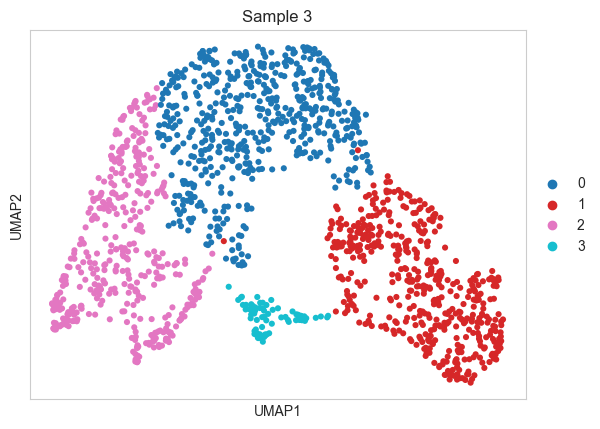

In [5]:
sc.tl.leiden(data_gene, resolution=0.15, key_added="leiden_opt", random_state=1234)
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

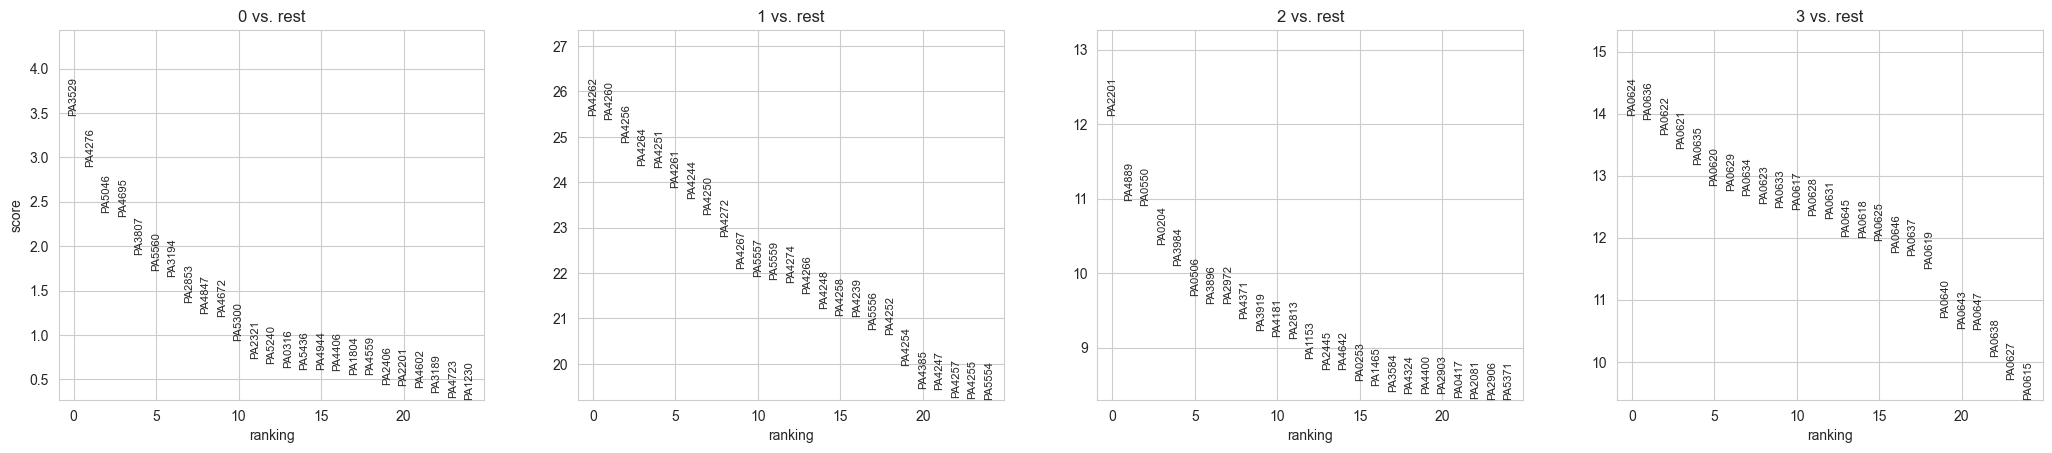

In [6]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

## Copula, direction 1

In [7]:
from scipy.stats import norm

rng = np.random.default_rng(1234)
X = ut.convert_to_dense_counts(data_gene, layer="counts")

means = data_gene.var["est_mean"]
overdisps = data_gene.var["est_overdisp"]
zinfs = data_gene.var["est_zero_inflation"]

n, p = X.shape
new_data_shape = (n, p)

# Do counts-to-uniform transforamation from scDesign
F = np.array([cd.dist_cdf_selector(X[:, j], means[j], overdisps[j], zinfs[j]) for j in range(p)]).T
F1 = np.array([cd.dist_cdf_selector(X[:, j] + 1, means[j], overdisps[j], zinfs[j]) for j in range(p)]).T

V = rng.uniform(0, 1, F.shape)
U = V * F + (1 - V) * F1
U[U == 1] = 0.99999

# Gaussian Copula
U_inv = norm.ppf(U, 0, 1)

# Estimate correlation matrix
R_est = np.corrcoef(U_inv.T)

# R_est = np.cov(U_inv.T)
# R_est[R_est < 0] = 0
# R_est = np.nan_to_num(R_est, nan=0, posinf=1, neginf=-1)

Estimated correlation matrix

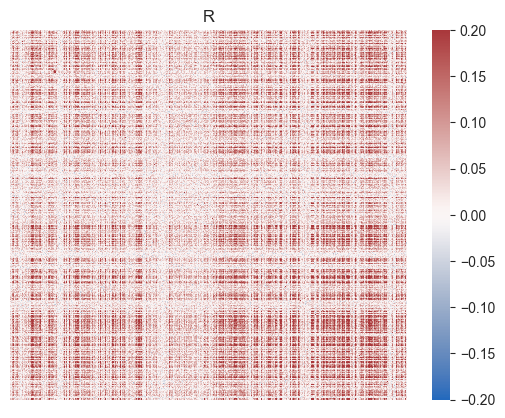

In [8]:
sns.heatmap(R_est,
            cmap='vlag', vmin=-0.2, vmax=0.2, center=0,
            xticklabels=False, yticklabels=False)
plt.title("R")
plt.show()

Generate similar correlation matrix, but with low rank

--> Easiest Way: rank-k SVD of R_est

In [9]:
U, S, V = np.linalg.svd(R_est)

In [55]:
k = 5
S_ = S
S_[k:] = 0

R_new = U @ np.diag(S_) @ V

var_factor = 2
# np.fill_diagonal(R_new, R_new.diagonal() * var_factor)
R_new = var_factor * R_new
print(R_new.shape)

(5553, 5553)


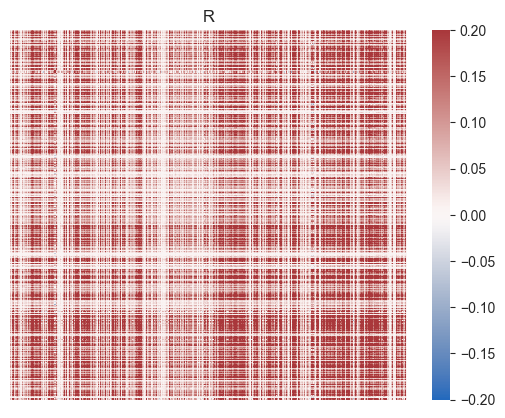

In [56]:
sns.heatmap(R_new,
            cmap='vlag', vmin=-0.2, vmax=0.2, center=0,
            xticklabels=False, yticklabels=False)
plt.title("R")
plt.show()

### Generate new data

In [57]:
Z = rng.multivariate_normal(mean=np.zeros(new_data_shape[1]), cov=R_new, size=new_data_shape[0])
Z_cdf = norm.cdf(Z)
Y_gen = np.array([cd.dist_ppf_selector(Z_cdf[:, j], means[j], overdisps[j], zinfs[j]) for j in
                  range(new_data_shape[1])]).T

# Make return anndata object
data_new_gen = ad.AnnData(X=Y_gen)
if new_data_shape == X.shape:
    data_new_gen.obs = pd.DataFrame(index=data_gene.obs.index)
    data_new_gen.var = pd.DataFrame(index=data_gene.var.index)

In [58]:
sc.pp.calculate_qc_metrics(data_new_gen)
data_new_gen.var["var_counts"] = np.asarray(np.var(data_new_gen.X, axis=0)).squeeze()
data_new_gen.var["mean_counts"] = np.asarray(np.mean(data_new_gen.X, axis=0)).squeeze()

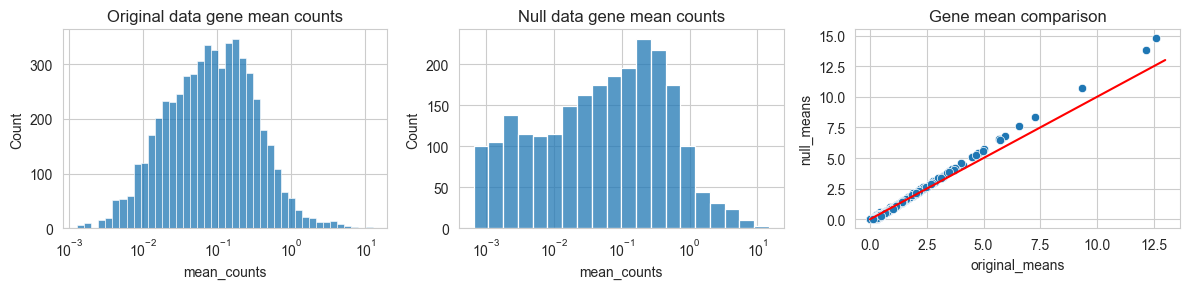

In [59]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_new_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df = pd.DataFrame({"original_means": data_gene.var["mean_counts"], "null_means": data_new_gen.var["mean_counts"]})
sns.scatterplot(mean_df, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

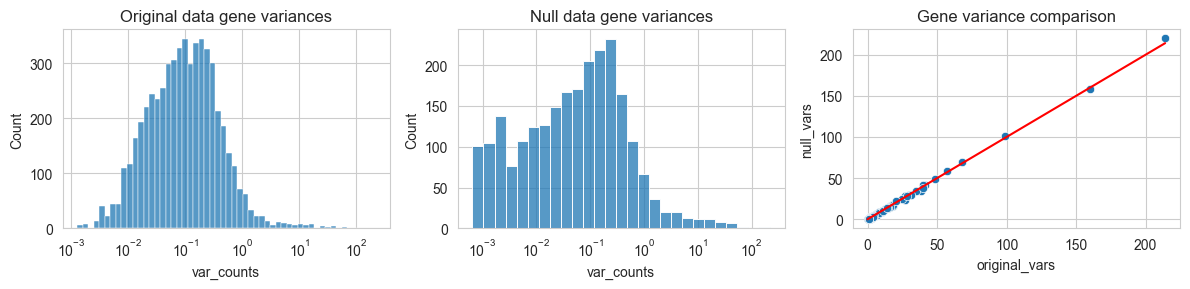

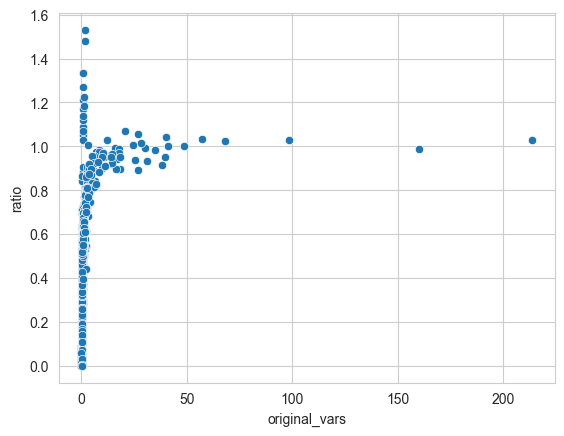

In [60]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_new_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df = pd.DataFrame({"original_vars": data_gene.var["var_counts"], "null_vars": data_new_gen.var["var_counts"]})
var_df["ratio"] = var_df["null_vars"] / var_df["original_vars"]
sns.scatterplot(var_df, y="null_vars", x="original_vars", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene.var["var_counts"]))], [0, np.ceil(np.max(data_gene.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

sns.scatterplot(var_df, x="original_vars", y="ratio")
plt.show()

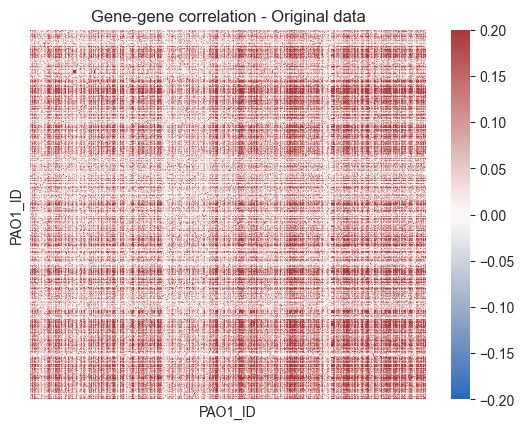

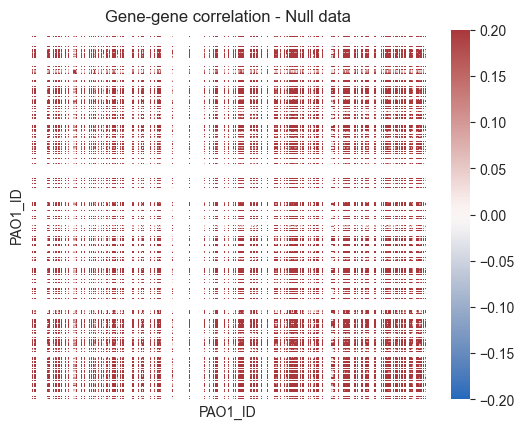

In [61]:
cor_orig = np.corrcoef(data_gene.layers["counts"].toarray().T)
cor_orig = pd.DataFrame(cor_orig, index=data_gene.var_names, columns=data_gene.var_names)

cor_gen = np.corrcoef(data_new_gen.X.T)
cor_gen = pd.DataFrame(cor_gen, index=data_gene.var_names, columns=data_gene.var_names)

sns.heatmap(cor_orig,
            cmap='vlag', vmin=-0.2, vmax=0.2, center=0,
            xticklabels=False, yticklabels=False)
plt.title("Gene-gene correlation - Original data")
plt.show()

sns.heatmap(cor_gen,
            cmap='vlag', vmin=-0.2, vmax=0.2, center=0,
            xticklabels=False, yticklabels=False)
plt.title("Gene-gene correlation - Null data")
plt.show()

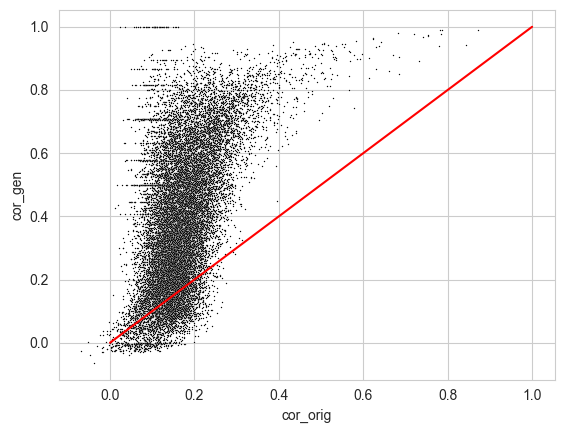

In [62]:
# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_orig": cor_orig.values.flatten(), "cor_gen": cor_gen.values.flatten(), "cor_null": cor_gen.values.flatten()})

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_orig'] < 0.99], x="cor_orig", y="cor_gen", s=1, color="black")
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_orig']))], [0, np.ceil(np.max(all_cors_subset['cor_orig']))], color="red")
plt.show()

### SVD of generated counts

In [75]:
U_gen, S_gen, V_gen = np.linalg.svd(data_new_gen.X)


<Axes: >

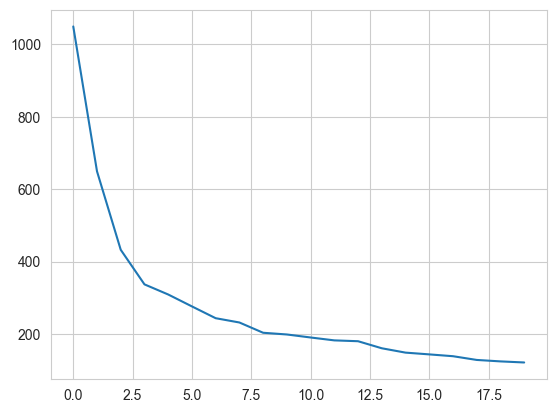

In [76]:
sns.lineplot(S_gen[:20])

### Processing and dimensionality check

In [77]:
data_new_gen.layers["counts"] = data_new_gen.X.copy()
nb.estimate_overdisp_nb(data_new_gen, flavor="statsmod_auto", layer="counts")

gene 0


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]


gene 100


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]


gene 200
gene 300


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]


gene 400


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]


gene 500


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/joh

gene 600
gene 700
gene 800


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]


gene 900


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/joh

gene 1000


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/joh

gene 1100
gene 1200


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]


gene 1300
gene 1400
gene 1500


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/joh

gene 1600


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/joh

gene 1700


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/joh

gene 1800


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/joh

gene 1900
gene 2000
gene 2100


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]


gene 2200
gene 2300


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]


gene 2400
gene 2500
gene 2600


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]


gene 2700


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/joh

gene 2800
gene 2900


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/joh

gene 3000


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]


gene 3100


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/joh

gene 3200


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]


gene 3300


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]


gene 3400
gene 3500


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]


gene 3600


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/joh

gene 3700


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/joh

gene 3800


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]


gene 3900


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]


gene 4000
gene 4100
gene 4200


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/joh

gene 4300


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/joh

gene 4400


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/joh

gene 4500


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/joh

gene 4600


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/joh

gene 4700


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/joh

gene 4800


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/joh

gene 4900


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/joh

gene 5000


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/joh

gene 5100


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/joh

gene 5200


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/joh

gene 5300


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]


gene 5400


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/joh

gene 5500


/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: invalid value encountered in log
  params = [np.log(const)]
/Users/joh

In [78]:
data_new_gen.var["nb_overdisp"] = np.nan_to_num(data_new_gen.var["est_overdisp"], posinf=1e-3)
data_new_gen.var["nb_mean"] = np.nan_to_num(data_new_gen.var["est_mean"], posinf=1e-3)


In [79]:
data_new_gen.X = data_new_gen.layers["counts"].copy()

In [80]:
k_opt = 3
n_neighbors_opt = 50
min_dist_opt = 0.3
res_opt = 0.15

sc.pp.calculate_qc_metrics(data_new_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
data_new_gen.layers["counts"] = data_new_gen.X.copy()
sc.pp.normalize_total(data_new_gen, target_sum=None, layer=None)
data_new_gen.X = sps.csr_matrix(np.log(data_new_gen.X + np.array(data_new_gen.var["nb_overdisp"] / 4)))
data_new_gen.layers["vst_counts"] = data_new_gen.X.copy()
sc.pp.scale(data_new_gen, max_value=10, zero_center=True)
data_new_gen.X[np.isnan(data_new_gen.X)] = 0

In [81]:
data_new_gen.var["gene_dist"].value_counts()

gene_dist
poi    3549
nb     2004
Name: count, dtype: int64

In [82]:
data_new_gen.var

,var_counts,mean_counts,gene_mean,gene_var,mean_var_diff,gene_dist,est_mean,est_overdisp,est_zero_inflation,nb_overdisp,nb_mean,n_cells_by_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,mean,std
PAO1_ID,,,,,,,,,,,,,,,,,,
PA0001,0.462541,2.330591e-14,0.295984,0.208378,0.087607,poi,0.295984,inf,0.00,0.001000,0.295984,1544,2.330591e-14,0.0,3.598433e-11,3.598433e-11,NaN,NaN
PA0002,0.307733,4.424699e-14,0.318005,0.225945,0.092060,poi,0.318005,inf,0.00,0.001000,0.318005,1544,4.424699e-14,0.0,6.831735e-11,6.831735e-11,NaN,NaN
PA0003,0.678444,9.184219e-15,-0.340674,0.336014,-0.676688,nb,NaN,20.000000,0.25,20.000000,0.000000,1544,9.184219e-15,0.0,1.418043e-11,1.418043e-11,NaN,NaN
PA0004,0.181290,6.348923e-14,0.262306,0.278994,-0.016688,nb,0.262306,3.236974,0.00,3.236974,0.262306,1544,6.348923e-14,0.0,9.802736e-11,9.802736e-11,NaN,NaN
PA0005,0.002584,-2.490413e-02,0.025907,0.258396,-0.232489,nb,0.025907,0.002430,0.00,0.002430,0.025907,1544,-2.521948e-02,0.0,-3.845197e+01,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PA5566,0.000000,0.000000e+00,0.000000,0.000000,0.000000,poi,0.000000,inf,0.00,0.001000,0.000000,0,0.000000e+00,100.0,0.000000e+00,0.000000e+00,-8.29405,NaN
PA5567,0.000000,0.000000e+00,0.000000,0.000000,0.000000,poi,0.000000,inf,0.00,0.001000,0.000000,0,0.000000e+00,100.0,0.000000e+00,0.000000e+00,-8.29405,NaN
PA5568,0.412021,2.503912e-14,0.313472,0.215207,0.098264,poi,0.313472,inf,0.00,0.001000,0.313472,1544,2.503912e-14,0.0,3.866041e-11,3.866041e-11,NaN,NaN


In [83]:
# nb.estimate_overdisp_nb(data_new_gen, flavor="BFGS", layer="counts")
data_train, data_test = cs.countsplit_adata(data_new_gen, data_dist="Poi", beta_key="nb_overdisp", layer="counts", min_genes=1, max_counts=1e9, seed=1234)
print(data_train)

ValueError: n < 0

In [ ]:
# Transformation, centering and PCA
sc.pp.normalize_total(data_train, target_sum=None, layer=None)
data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp"] / 4)))
data_train.layers["vst_counts"] = data_train.X.copy()
sc.pp.scale(data_train, max_value=10, zero_center=True)
sc.tl.pca(data_train, svd_solver='arpack')


sc.pp.normalize_total(data_test, target_sum=None, layer=None)
data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_test.var["nb_overdisp"] / 4)))
data_test.layers["vst_counts"] = data_test.X.copy()
sc.pp.scale(data_test, max_value=10, zero_center=True)
sc.tl.pca(data_test, svd_solver='arpack')

In [ ]:
sc.pl.pca(data_train, title="Training data", color="total_counts")
plt.show()

sc.pl.pca(data_test, title="Test data", color="total_counts")
plt.show()

In [ ]:
k_errors, k_opt = cs.select_n_pcs_countsplit(data_train, data_test)
print(f"Optimal number of PCs:{k_opt}")

plt.scatter(np.arange(20) + 1, k_errors)
plt.title("SVD loss")
plt.xlabel("Dimensionality")
plt.ylabel("Loss")
plt.show()